# Project 4: Unsupervised Learning
# Data Set: CIFAR-10 - Object Recognition in Images
_Identify the subject of 60,000 labeled images_

**Project Description**: _"[CIFAR-10](https://www.kaggle.com/c/cifar-10/)  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton."_

For this project, 2500 random images were selected.

## 1. Introduction

In [1]:
import numpy as np
import pandas as pd
import cv2
import time
import os, os.path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import seaborn as sns; sns.set_style("whitegrid")

#from keras.datasets import cifar10
#from google.colab.patches import cv2_imshow

***
***
**Sandbox Cells:**<br>

In [2]:
os.listdir("train/")[0:5]

['1.png', '10.png', '100.png', '1000.png', '10000.png']

In [3]:
os.path.splitext(os.listdir("train")[1])

('10', '.png')

***
---

In [4]:
# labels of the 50,000 train images
df_labels = pd.read_csv("trainLabels.csv", index_col="id")

# For convenience, convert the labels to numbers in alphabetical order
df_labels["label #"] = df_labels.label
labels_ordered = enumerate(sorted(df_labels.label.unique()), start=0)
for num, label in labels_ordered:
    df_labels["label #"].replace(to_replace=label, value=num, inplace=True)
df_labels["label #"] = df_labels["label #"].astype("uint8")
del labels_ordered

df_labels.head()

,label,label #
id,,
1,frog,6
2,truck,9
3,truck,9
4,deer,4
5,automobile,1


In [5]:
%%time

# Here we create indices for 2500 random images
np.random.seed(42)
indices = np.random.choice(50000,2500)

# To make things faster, numpy arrays were formed
# They will be concatenated later on a DataFrame
image_array = np.empty(shape=(2500,2500), dtype="uint8")    ## u can make these simpler
label_array = np.empty(shape=(2500,1), dtype="object")
label_num = np.empty(shape=(2500,1), dtype="uint8")
name_array = np.empty(shape=(2500,1), dtype="object")

# Now let's get the images and put them into numpy array we crated
for num, indx in enumerate(indices):
    path = f"train/{indx}.png"
    img_array = cv2.imread(path, 0)
    img_array = cv2.resize(img_array, (50,50))
    image_array[num] = img_array.reshape(-1)
    label_array[num] = df_labels.loc[indx, "label"]
    label_num[num] = df_labels.loc[indx, "label #"]
    name_array[num] = str(indx) + ".png"

# summon a DataFrame to work on them easier
train_df = pd.DataFrame(image_array)
train_df["Img Name"] = name_array
train_df["Label"] = label_array
train_df["Label #"] = label_num

Wall time: 1.06 s


In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2493,2494,2495,2496,2497,2498,2499,Img Name,Label,Label #
0,75,85,102,140,164,179,152,134,127,121,...,43,35,34,29,20,27,35,15795.png,cat,3
1,172,170,167,166,166,167,167,167,166,167,...,10,19,19,20,24,48,67,860.png,ship,8
2,74,75,77,74,68,61,79,92,98,95,...,82,82,81,81,82,82,82,38158.png,automobile,1
3,240,239,238,238,239,240,240,240,239,239,...,44,33,28,25,25,32,38,44732.png,airplane,0
4,249,247,245,245,244,243,243,243,243,243,...,203,204,206,209,210,215,218,11284.png,airplane,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Columns: 2503 entries, 0 to Label #
dtypes: object(2), uint8(2501)
memory usage: 6.0+ MB


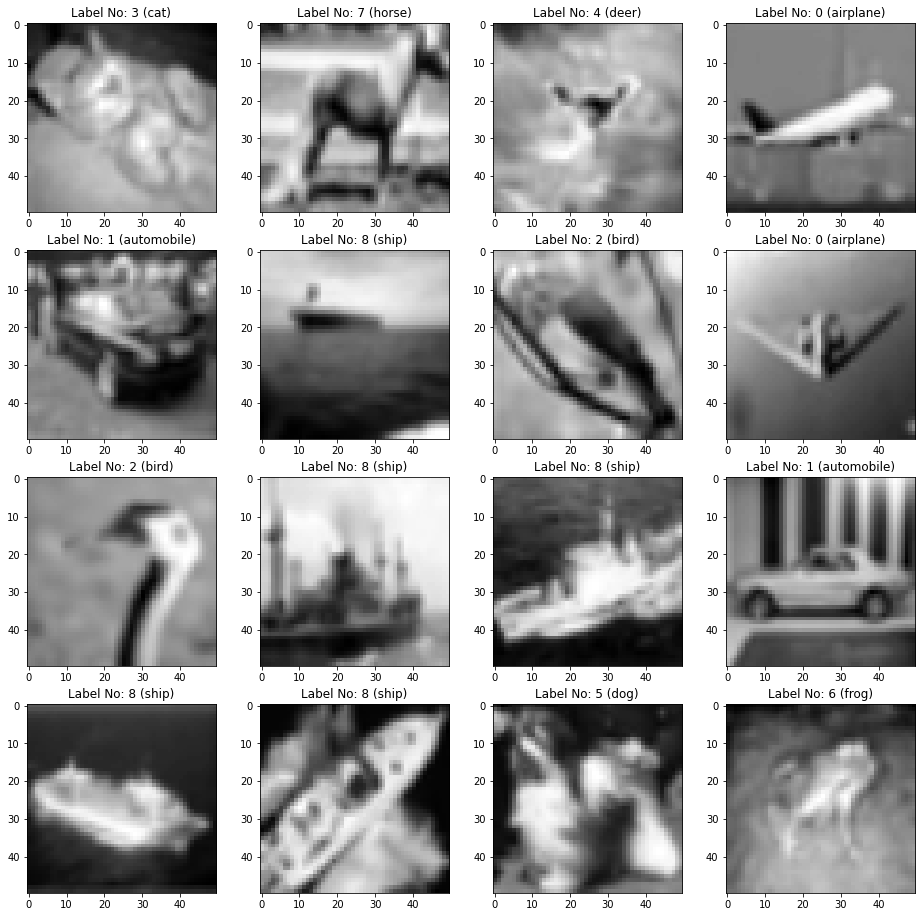

In [8]:
# some of the random choice images
plt.figure(figsize=(16,16))
subplot_num = 1
for i in np.random.randint(0,2500,16):
    plt.subplot(4,4,subplot_num)
    example = np.resize(train_df.iloc[i, :], (50,50)).astype("uint8")
    plt.imshow(example, cmap="gray")
    label = df_labels.loc[indices[i], "label"]
    label_no = train_df.loc[i, "Label #"]
    plt.title(f"Label No: {label_no} ({label})", size=12)
    subplot_num+=1
plt.show()
del subplot_num

## 2. Dimensionality Reduction Study

In [9]:
# defining independent variables, X & Y
X = train_df.iloc[:, :-3]
Y = train_df["Label #"]

### 2.1. Principle Component Analysis (PCA)

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
# standardize the values
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

c:\program files\python38\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


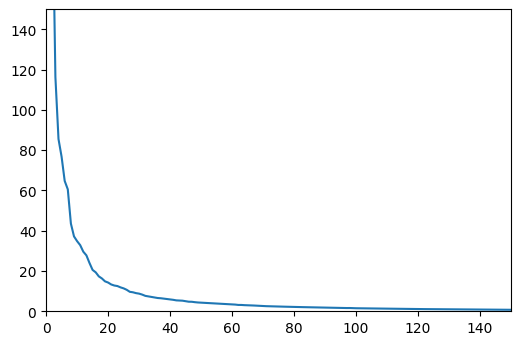

In [12]:
# we'll see the variation distribution through the eigenvalues
def eig_vals():
    X_std_T = X_std.T
    C_X = np.cov(X_std_T)
    eig_val_cov, eig_vec_cov = np.linalg.eig(C_X)

    plt.figure(dpi=100)
    plt.plot(eig_val_cov)
    plt.xlim(0,150)
    plt.ylim(0,150)
    plt.show()
eig_vals()

In [14]:
# let's take 100 components on our PCA model
# NOTE: This cell might need to be run twice! (possible bug?)
pca_model = PCA(n_components=100)
X_pca = pca_model.fit_transform(X_std)

print(f"With {pca_model.n_components_} components, our model explains \
{sum(pca_model.explained_variance_ratio_)*100:.1f}% of our data.")

With 100 components, our model explains 94.9% of our data.


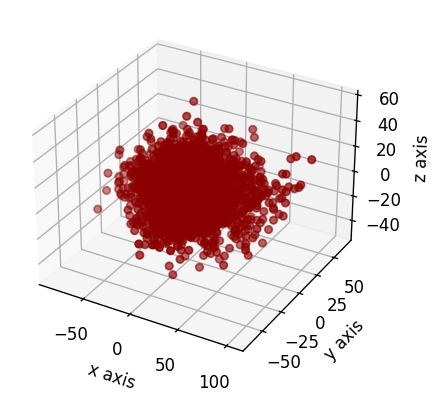

In [15]:
def plot_3D(independent_variable, interaction="passive", color="darkred"):
    """Note that, we have a bug:
    May need to run the cell a few times to view it in interactive mode."""
    if interaction == "passive":
        %matplotlib inline
    elif interaction == "active":
        %matplotlib notebook
    else:
        return "Only 'passive' & 'active' modes are valid."
    
    fig=plt.figure(dpi=120)
    ax=fig.add_subplot(111, projection="3d")

    ax.scatter(independent_variable.T[0], 
               independent_variable.T[1], 
               independent_variable.T[2], 
               color=color)
    ax.set_xlabel("x axis")
    ax.set_ylabel("y axis")
    ax.set_zlabel("z axis")
    plt.show()

plot_3D(X_pca, "passive")

In [16]:
# Not enough memory to run this cell. Needs to be fixed.
def pca_visualiser():
    for i in range(10):
        train_df.Label[train_df.Label == train_df.Label.unique()[i]] = i

    y = list(train_df.Label)

    plt.figure()
    colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
    
    for i in range(X_pca.shape[0]):
        plt.text(X_pca[i, 0], X_pca[i, 1], str(y[i]),
                 color=colours[int(y[i])],
                 fontdict={'weight': 'bold', 'size': 50})
    plt.xticks([])
    plt.yticks([])
    plt.show()

#%matplotlib inline 
#pca_visualiser()

### 2.2. t-distributed Stochastic Neighbor Embedding (t-SNE)

In [17]:
from sklearn.manifold import TSNE

In [18]:
# t-SNE model 1 with perplexity=5
time_start = time.time()
tsne_model1 = TSNE(n_components=3, 
                   perplexity=5, 
                   n_iter=1000, 
                   verbose=True, 
                   n_jobs=-1)
X_tsne1 = tsne_model1.fit_transform(X_std)
print(f"t-SNE is completed in {(time.time()-time_start):.1f} seconds.")

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2500 samples in 1.550s...
[t-SNE] Computed neighbors for 2500 samples in 11.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 7.343899
[t-SNE] KL divergence after 250 iterations with early exaggeration: 121.272110
[t-SNE] KL divergence after 1000 iterations: 2.436354
t-SNE is completed in 78.1 seconds.


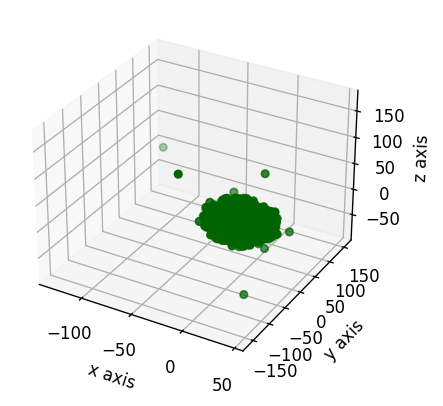

In [19]:
plot_3D(X_tsne1, "passive", "darkgreen")

In [20]:
# t-SNE model 1 with perplexity=40
time_start = time.time()
tsne_model2 = TSNE(n_components=3, 
                   perplexity=40, 
                   n_iter=1000, 
                   verbose=False, 
                   n_jobs=-1)
X_tsne2 = tsne_model2.fit_transform(X_std)
print(f"t-SNE is completed in {(time.time()-time_start):.1f} seconds.")

t-SNE is completed in 97.7 seconds.


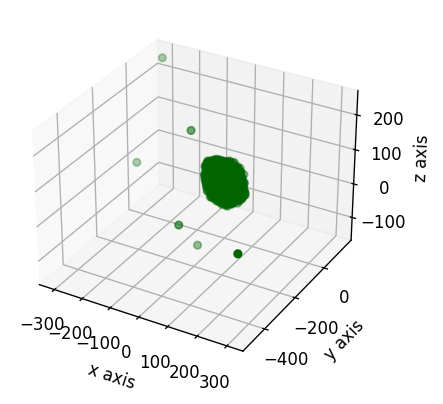

In [21]:
plot_3D(X_tsne2, "passive", "darkgreen")

### 2.3. Uniform Manifold Approximation and Projection (UMAP)

In [36]:
from umap import UMAP

In [37]:
# UMAP model 1
time_start = time.time()
umap_model1 = UMAP(n_neighbors=5,
                   min_dist=0.1,
                   metric="correlation", 
                   n_components=3, 
                   verbose=True)
X_umap1 = umap_model1.fit_transform(X_std)
print(f"UMAP modeling is completed in {(time.time()- time_start):.2f} seconds.")

UMAP(angular_rp_forest=True, metric='correlation', n_components=3,
     n_neighbors=5, verbose=True)
Construct fuzzy simplicial set
Thu Sep 24 15:46:42 2020 Finding Nearest Neighbors
Thu Sep 24 15:46:42 2020 Finished Nearest Neighbor Search
Thu Sep 24 15:46:42 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Sep 24 15:46:47 2020 Finished embedding
UMAP modeling is completed in 37.19 seconds.


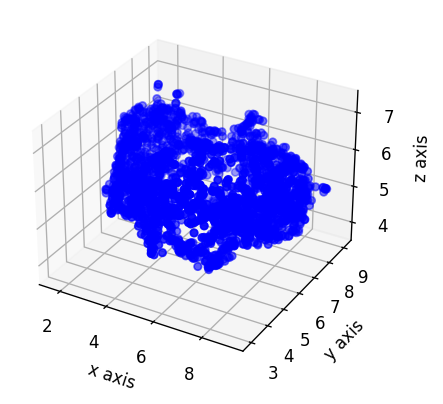

In [38]:
plot_3D(X_umap1, "passive", "blue")

In [39]:
# UMAP model 2
time_start = time.time()
umap_model2 = UMAP(n_neighbors=15,
                   min_dist=0.1,
                   metric="euclidean", 
                   n_components=3, 
                   verbose=False)
X_umap2 = umap_model2.fit_transform(X_std)
print(f"UMAP modeling is completed in {(time.time()- time_start):.2f} seconds.")

UMAP modeling is completed in 12.90 seconds.


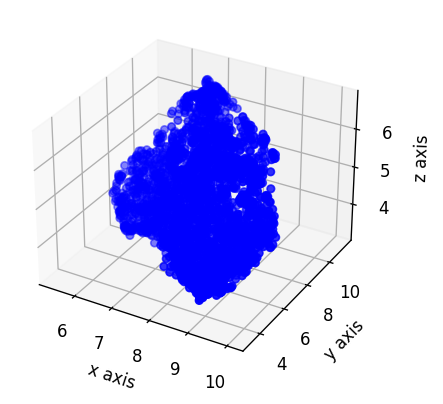

In [40]:
plot_3D(X_umap2, "passive", "blue")

# 3. Clustering Models

In [41]:
clusters_df = pd.DataFrame()
clusters_df["Img Name"] = train_df["Img Name"]
clusters_df["Label"] = train_df.Label
clusters_df["Label #"] = train_df["Label #"]

## 3.1. k-Means

In [42]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [43]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

# function for KMeans model
def kmeans_model(var):
    """The Return is a list of length three: [y, z1, z2]
    y: prediction of your KMeans model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to 
    get the returns y, z1 & z2 respectively.
    And remember: 'var' is your independent variable!"""
    kmodel = KMeans(n_clusters=10, random_state=42)
    y = kmodel.fit_predict(var)
    z1 = metrics.silhouette_score(X=var, 
                                 labels=y, 
                                 metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=Y, 
                                     labels_pred=y)
    return [y, z1, z2]

In [46]:
%%time
def add_to_cluster_df(model_name, model):
    clusters_df[f"{model_name}_std"] = model(X_std)[0]
    clusters_df[f"{model_name}_pca"] = model(X_pca)[0]
    clusters_df[f"{model_name}_tsne1"] = model(X_tsne1)[0]
    clusters_df[f"{model_name}_tsne2"] = model(X_tsne2)[0]
    clusters_df[f"{model_name}_umap1"] = model(X_umap1)[0]
    clusters_df[f"{model_name}_umap2"] = model(X_umap2)[0]
add_to_cluster_df("kmeans", kmeans_model)

Wall time: 10.2 s


In [48]:
def show_silhouette(model_name, model):
    print(f"Silhouette score of '{model_name}_std' model: {(model(X_std)[1]):.3f}")
    print(f"Silhouette score of '{model_name}_pca' model: {(model(X_pca)[1]):.3f}")
    print(f"Silhouette score of '{model_name}_tsne1' model: {(model(X_tsne1)[1]):.3f}")
    print(f"Silhouette score of '{model_name}_tsne2' model: {(model(X_tsne2)[1]):.3f}")
    print(f"Silhouette score of '{model_name}_umap1' model: {(model(X_umap1)[1]):.3f}")
    print(f"Silhouette score of '{model_name}_umap2' model: {(model(X_umap2)[1]):.3f}")
show_silhouette("kmeans", kmeans_model)

Silhouette score of 'kmeans_std' model: 0.059
Silhouette score of 'kmeans_pca' model: 0.067
Silhouette score of 'kmeans_tsne1' model: 0.273
Silhouette score of 'kmeans_tsne2' model: 0.251
Silhouette score of 'kmeans_umap1' model: 0.319
Silhouette score of 'kmeans_umap2' model: 0.311


In [49]:
def show_ari(model_name, model):
    print(f"Adjusted Rand score of '{model_name}_std' model: {(model(X_std)[2]):.4f}")
    print(f"Adjusted Rand score of '{model_name}_pca' model: {(model(X_pca)[2]):.4f}")
    print(f"Adjusted Rand score of '{model_name}_tsne1' model: {(model(X_tsne1)[2]):.4f}")
    print(f"Adjusted Rand score of '{model_name}_tsne2' model: {(model(X_tsne2)[2]):.4f}")
    print(f"Adjusted Rand score of '{model_name}_umap1' model: {(model(X_umap1)[2]):.4f}")
    print(f"Adjusted Rand score of '{model_name}_umap2' model: {(model(X_umap2)[2]):.4f}")
show_ari("kmeans", kmeans_model)

Adjusted Rand score of 'kmeans_std' model: 0.0331
Adjusted Rand score of 'kmeans_pca' model: 0.0320
Adjusted Rand score of 'kmeans_tsne1' model: 0.0329
Adjusted Rand score of 'kmeans_tsne2' model: 0.0369
Adjusted Rand score of 'kmeans_umap1' model: 0.0317
Adjusted Rand score of 'kmeans_umap2' model: 0.0329


## 3.2. Hierarchical (Agglomerative) Clustering

In [50]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

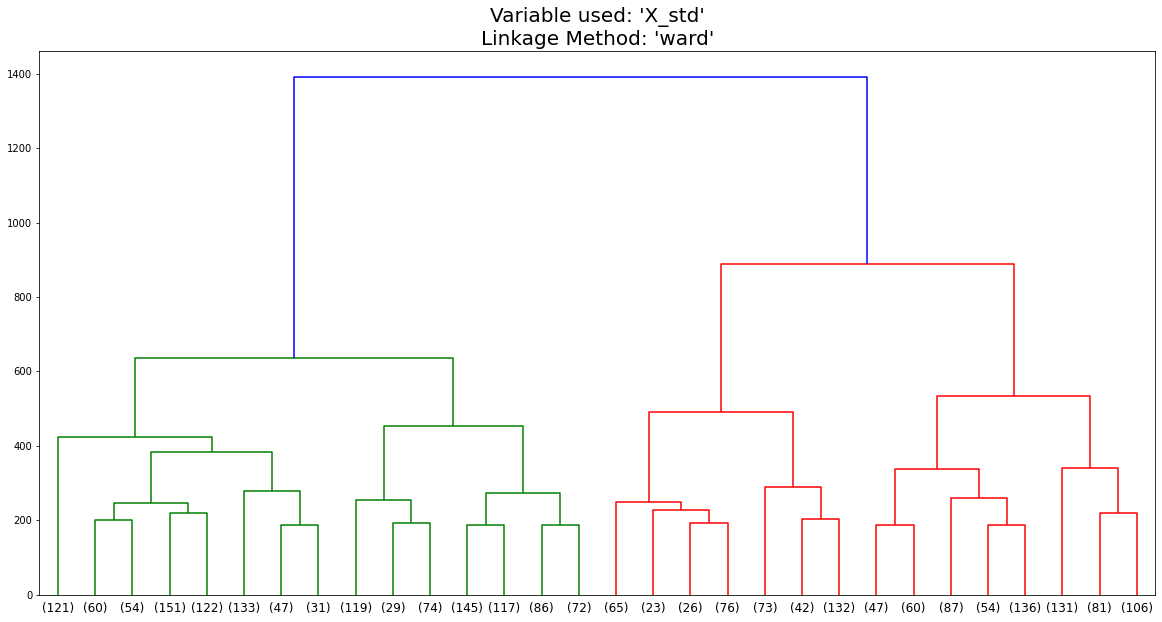

In [51]:
# dendrogram example with X_std variable
plt.figure(figsize=(20,10))
plt.title("Variable used: 'X_std'\nLinkage Method: 'ward'", size=20)
Z = linkage(X_std, 
            method="ward", 
            metric="euclidean")
dendrogram(Z=Z, 
           truncate_mode="lastp", 
           leaf_font_size=12, 
           leaf_rotation=0)
plt.show()

In [52]:
# list of independent variables created above:
# X_std, X_pca, X_tsne1, X_tsne2, X_umap1, X_umap2

# function for AgglomerativeClustering model
def aggClus_model(var):
    """The Return is a list of length three: [y, z1, z2]
    y: prediction of your AgglomerativeClustering model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to 
    get the returns y, z1 & z2 respectively.
    And remember: 'var' is your independent variable!"""
    aggClus_model = AgglomerativeClustering(n_clusters=10,
                                            affinity="euclidean",
                                            linkage="ward")
    y = aggClus_model.fit_predict(var)
    z1 = metrics.silhouette_score(X=var, 
                                 labels=y, 
                                 metric="euclidean")
    z2 = metrics.adjusted_rand_score(labels_true=Y, 
                                     labels_pred=y)
    return [y, z1, z2]

In [56]:
%%time
add_to_cluster_df("aggClus", aggClus_model)

Wall time: 11.1 s


In [57]:
show_silhouette("aggClus", aggClus_model)

Silhouette score of 'aggClus_std' model: 0.028
Silhouette score of 'aggClus_pca' model: 0.041
Silhouette score of 'aggClus_tsne1' model: 0.207
Silhouette score of 'aggClus_tsne2' model: 0.193
Silhouette score of 'aggClus_umap1' model: 0.312
Silhouette score of 'aggClus_umap2' model: 0.284


In [58]:
show_ari("aggClus", aggClus_model)

Adjusted Rand score of 'aggClus_std' model: 0.0350
Adjusted Rand score of 'aggClus_pca' model: 0.0296
Adjusted Rand score of 'aggClus_tsne1' model: 0.0388
Adjusted Rand score of 'aggClus_tsne2' model: 0.0312
Adjusted Rand score of 'aggClus_umap1' model: 0.0311
Adjusted Rand score of 'aggClus_umap2' model: 0.0342


## 3.3. Density-based Spatial Clustering of Applications with Noise (DBSCAN)

In [60]:
from sklearn.cluster import DBSCAN

In [112]:
def dbscan_model(var):
    """The Return is a list of length three: [y, z1, z2]
    y: prediction of your DBSCAN model,
    z1: silhouette score,
    z2: adjusted Rand score of the model.
    Please use the indices 0, 1 & 2 to 
    get the returns y, z1 & z2 respectively.
    And remember: 'var' is your independent variable!"""
    dbscan_model = DBSCAN(eps=8, 
                          min_samples=3, 
                          metric="euclidean", 
                          leaf_size=30, 
                          n_jobs=-1)
    y = dbscan_model.fit_predict(var)
    try:
        z1 = metrics.silhouette_score(X=var, 
                                     labels=y, 
                                     metric="euclidean")
    except ValueError:
        z1 = np.nan
    z2 = metrics.adjusted_rand_score(labels_true=Y, 
                                     labels_pred=y)
    return [y, z1, z2]

In [113]:
%%time
add_to_cluster_df("dbscan", dbscan_model)

Wall time: 32.7 s


In [118]:
# prediction models and their cluster numbers
for i in clusters_df.columns[-6:]:
    predict_count = len(np.unique(clusters_df[i], return_counts=True)[0])
    print(f"Number of predicted clusters for '{i}' model:", predict_count)

Number of predicted clusters for 'dbscan_std' model: 2
Number of predicted clusters for 'dbscan_pca' model: 2
Number of predicted clusters for 'dbscan_tsne1' model: 3
Number of predicted clusters for 'dbscan_tsne2' model: 19
Number of predicted clusters for 'dbscan_umap1' model: 1
Number of predicted clusters for 'dbscan_umap2' model: 1


In [115]:
show_silhouette("dbscan", dbscan_model)

Silhouette score of 'dbscan_std' model: -0.015
Silhouette score of 'dbscan_pca' model: -0.014
Silhouette score of 'dbscan_tsne1' model: 0.106
Silhouette score of 'dbscan_tsne2' model: -0.481
Silhouette score of 'dbscan_umap1' model: nan
Silhouette score of 'dbscan_umap2' model: nan


In [116]:
show_ari("dbscan", dbscan_model)

Adjusted Rand score of 'dbscan_std' model: -0.0000
Adjusted Rand score of 'dbscan_pca' model: -0.0000
Adjusted Rand score of 'dbscan_tsne1' model: -0.0000
Adjusted Rand score of 'dbscan_tsne2' model: 0.0006
Adjusted Rand score of 'dbscan_umap1' model: 0.0000
Adjusted Rand score of 'dbscan_umap2' model: 0.0000


## 3.4. Gaussian Mixture Model (GMM)